In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Prep Data

In [55]:
path = '/content/drive/My Drive/Colab Notebooks/job_satisfaction_project'

In [56]:
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

In [57]:
# only full time positions
train = train.loc[train['full_time'] == 1]
test = test.loc[test['full_time'] == 1]

In [42]:
# same features used in the ordinal regression models
features = ['religion', 'ethnicity', 'gender', 'highest_grade', 'urban', 'net_family_income',
            'job_number', 'union', 'public', 'hourly_pay', 'avg_age_per_job', 
            'tenure', 'rotter_score', 'rosenberg_score', 'pay_tenure', 'pay_age']

In [8]:
def prep_data(data, features):
  clusters = data['id']
  X = pd.get_dummies(data[features])
  Z = np.ones((len(X), 1))
  y = data['job_satisfaction'].values
  return X, Z, clusters, y

In [9]:
X_train, Z_train, clusters_train, y_train = prep_data(train, features)
X_test, Z_test, clusters_test, y_test = prep_data(test, features)

MERF

In [3]:
!pip install -q MERF

In [4]:
from merf import MERF

In [12]:
mrf = MERF(max_iterations=10)

In [13]:
mrf.fit(X_train, Z_train, clusters_train, y_train)

In [14]:
pickle.dump(mrf, open(f'{path}/merf.sav', 'wb'))

In [15]:
y_pred = mrf.predict(X_test, Z_test, clusters_test)

In [16]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 0.7231966233743033
R-squared: 0.08216647731299831


SHAP

In [5]:
!pip install -q shap

In [6]:
import shap

In [7]:
mrf = pickle.load(open(f'{path}/merf.sav', 'rb'))

In [8]:
explainer = shap.TreeExplainer(mrf.trained_fe_model, feature_perturbation='tree_path_dependent')  # for colinearity

In [ ]:
X_test = X_test.sample(frac = 1, random_state=0)

X_test.to_csv(f'{path}/X_test_for_shap.csv', index=False)

for i in range(0, len(X_test), 100):
  print(f'Starting pipeline for {i}')
  shap_values = explainer.shap_values(X_test[i:i+99], check_additivity=False)
  np.save(f'{path}/shap_values_{i}.npy', shap_values)
  print(f'Saved SHAP values for {i} - {i + 99}.')

Starting pipeline for 0
Saved SHAP values for 0 - 99.
Starting pipeline for 100
Saved SHAP values for 100 - 199.
Starting pipeline for 200
Saved SHAP values for 200 - 299.
Starting pipeline for 300
Saved SHAP values for 300 - 399.
Starting pipeline for 400
Saved SHAP values for 400 - 499.
Starting pipeline for 500
Saved SHAP values for 500 - 599.
Starting pipeline for 600
Saved SHAP values for 600 - 699.
Starting pipeline for 700
Saved SHAP values for 700 - 799.
Starting pipeline for 800
Saved SHAP values for 800 - 899.
Starting pipeline for 900
Saved SHAP values for 900 - 999.
Starting pipeline for 1000
Saved SHAP values for 1000 - 1099.
Starting pipeline for 1100
Saved SHAP values for 1100 - 1199.
Starting pipeline for 1200
Saved SHAP values for 1200 - 1299.
Starting pipeline for 1300
Saved SHAP values for 1300 - 1399.
Starting pipeline for 1400
Saved SHAP values for 1400 - 1499.
Starting pipeline for 1500
Saved SHAP values for 1500 - 1599.
Starting pipeline for 1600
Saved SHAP value

In [9]:
X_test = pd.read_csv(f'{path}/X_test_for_shap.csv')

In [32]:
shap_values = np.load(f'{path}/shap_values_0.npy')

for item in os.listdir(path):
  if '.npy' in item and item != 'shap_values_0.npy': 
    shap_values = np.concatenate((shap_values, np.load(f'{path}/{item}')), axis=0)

In [35]:
print(f"SHAP values calculated for {shap_values.shape[0]} test observations.")

SHAP values calculated for 1782 test observations.


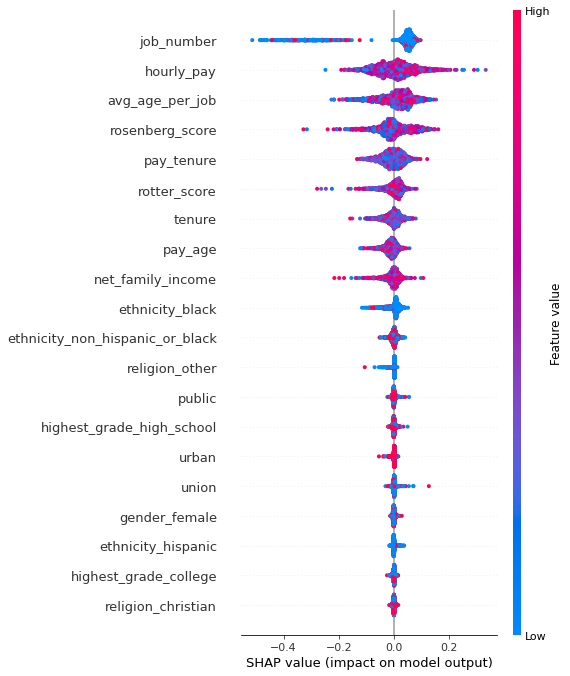

In [34]:
shap.summary_plot(shap_values, X_test[:shap_values.shape[0]])

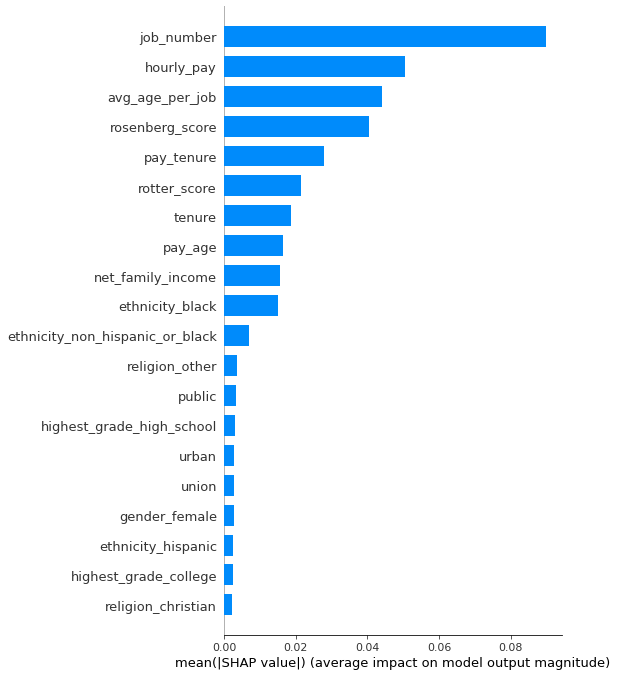

In [36]:
# feature importance
shap.summary_plot(shap_values, X_test[:shap_values.shape[0]], plot_type="bar")

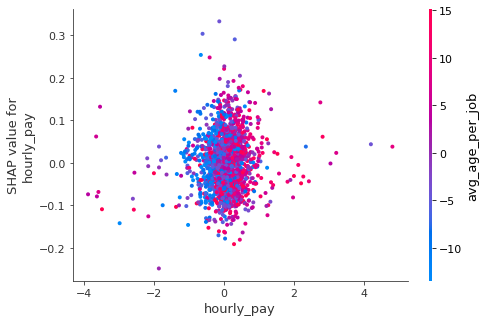

In [37]:
shap.dependence_plot("hourly_pay", shap_values, X_test[:shap_values.shape[0]], interaction_index="avg_age_per_job")

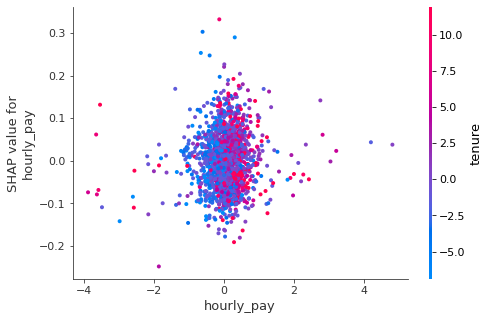

In [38]:
shap.dependence_plot("hourly_pay", shap_values, X_test[:shap_values.shape[0]], interaction_index="tenure")

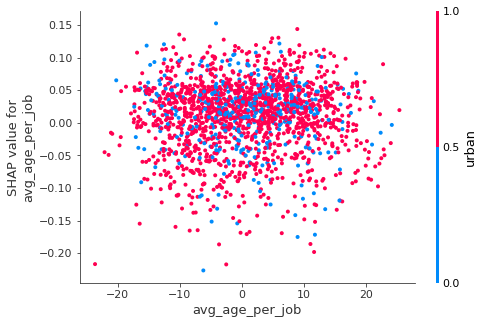

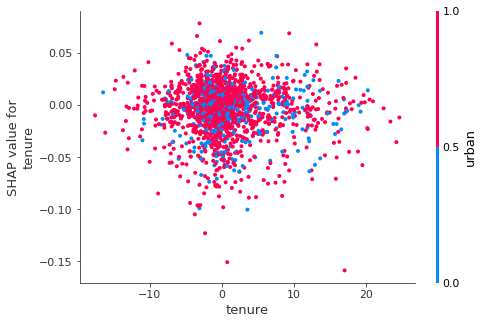

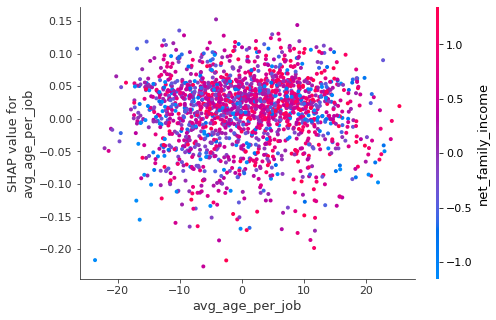

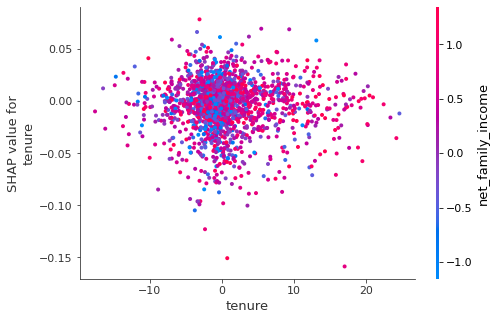

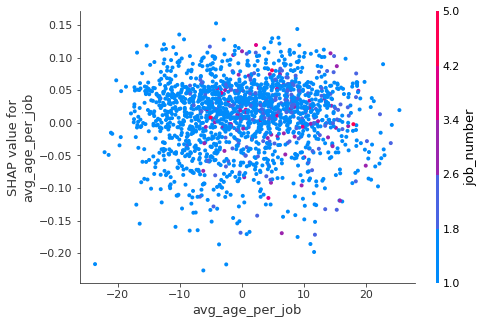

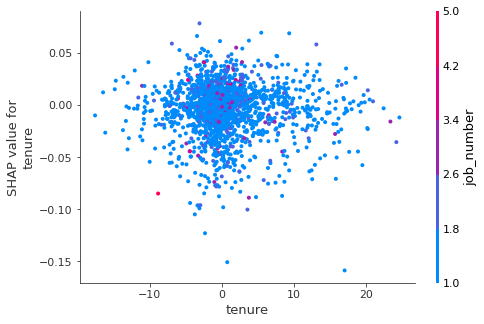

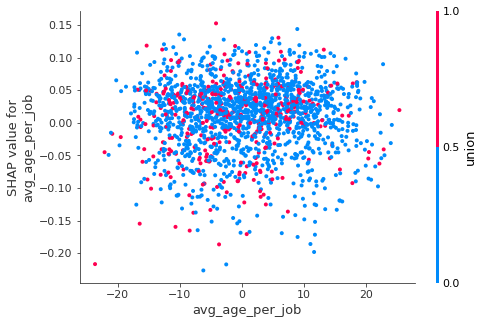

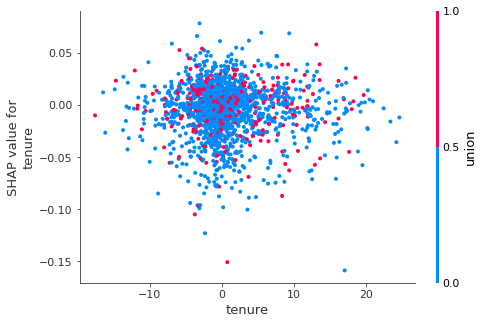

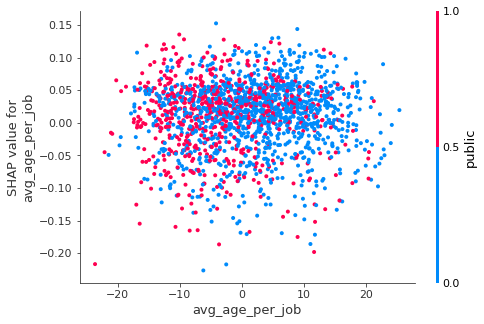

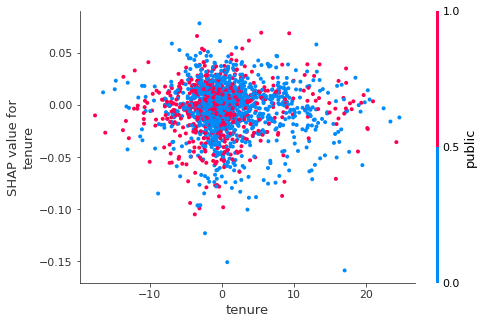

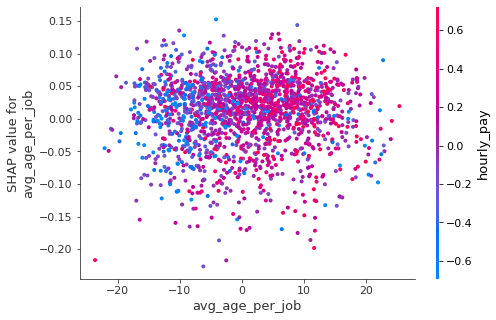

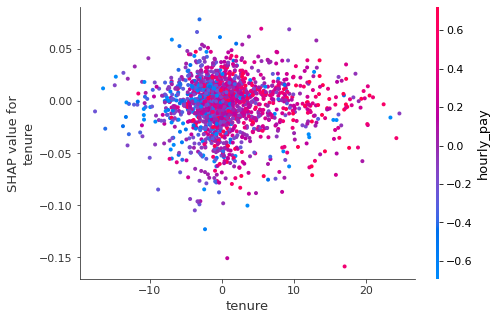

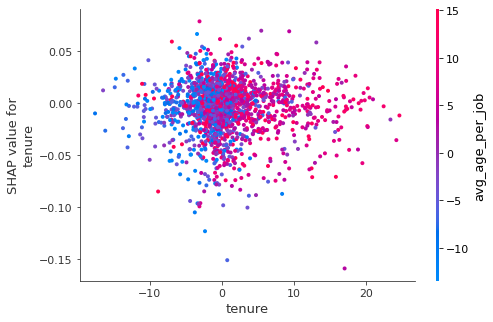

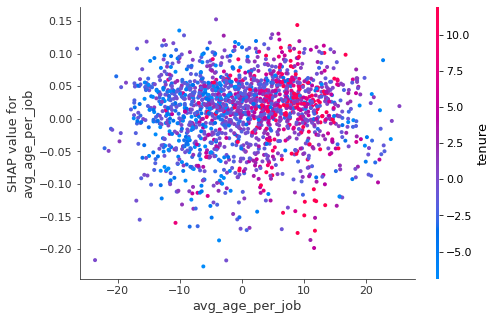

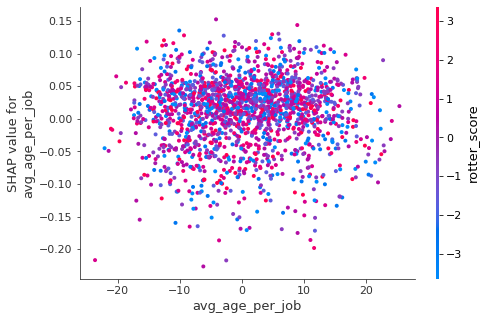

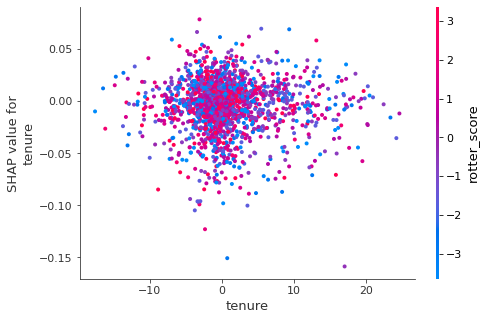

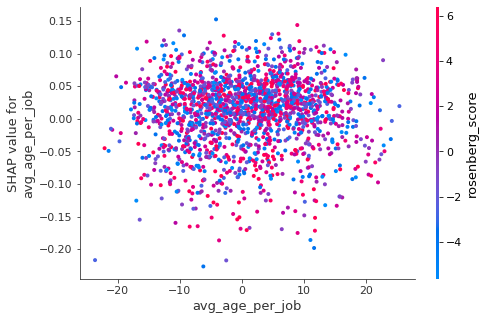

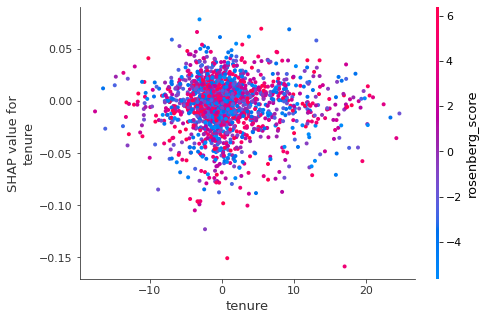

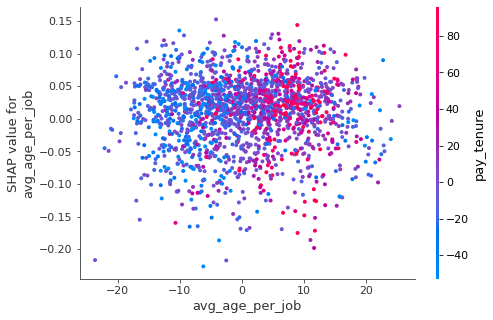

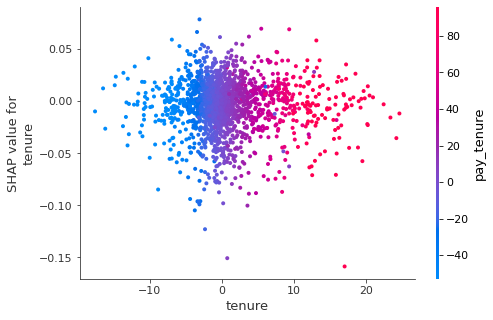

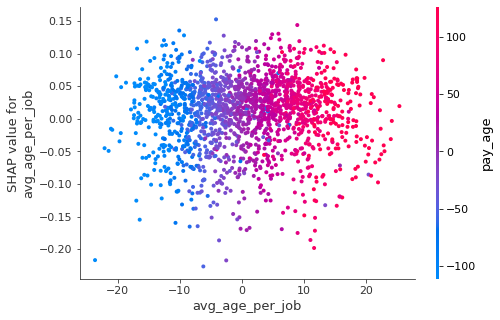

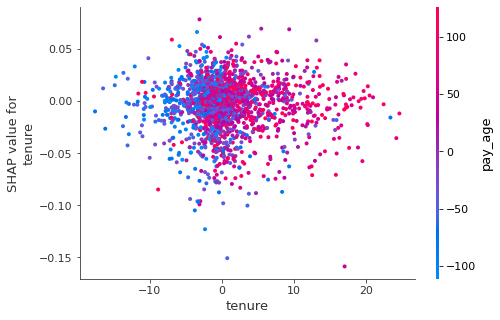

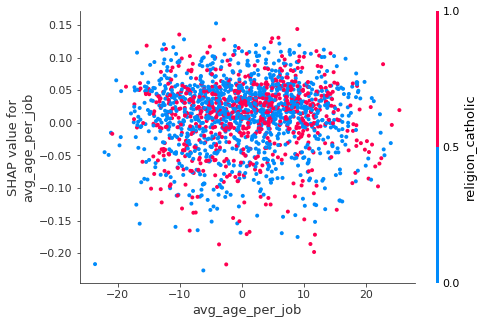

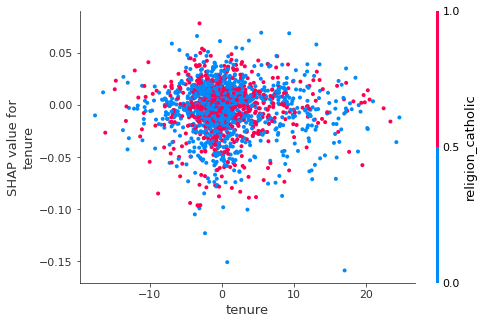

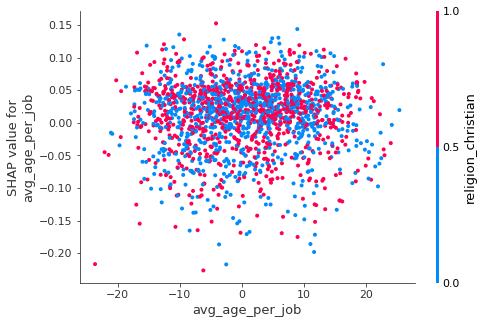

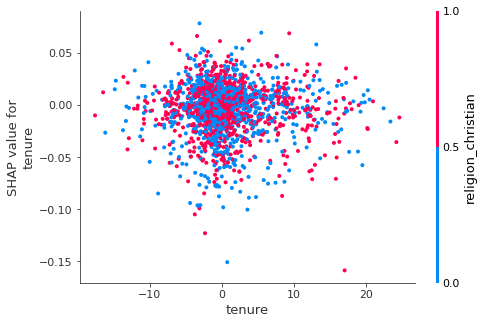

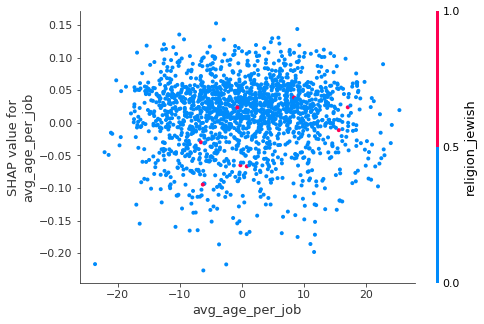

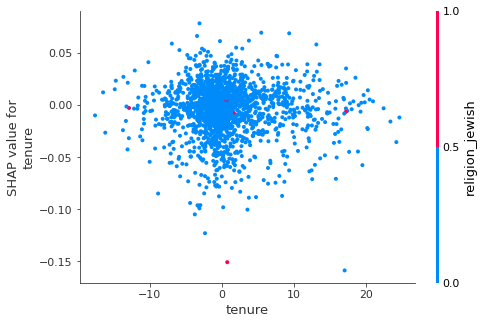

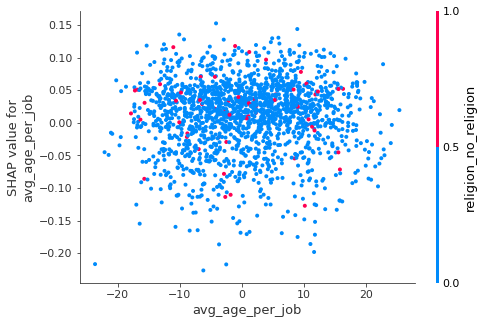

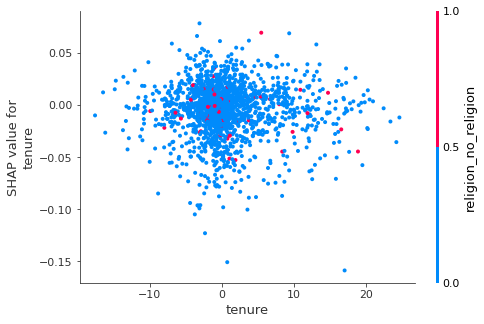

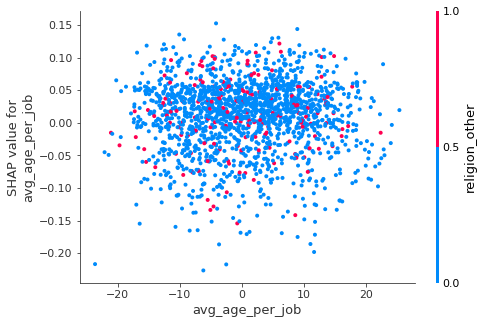

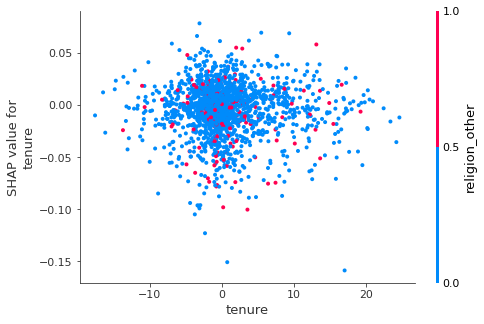

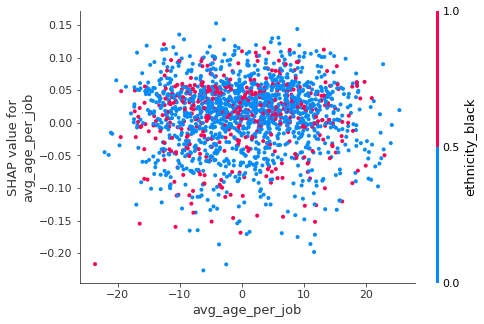

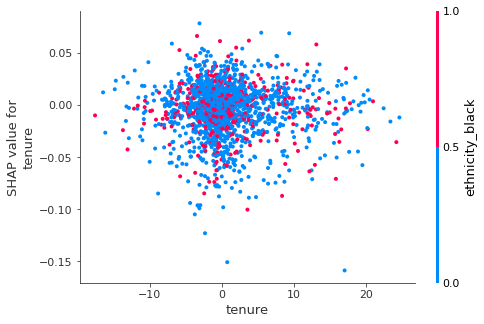

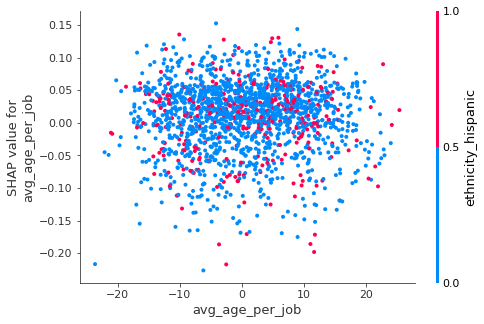

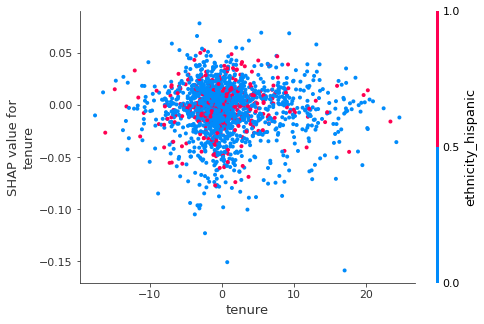

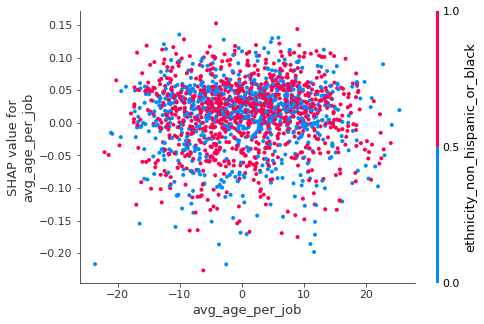

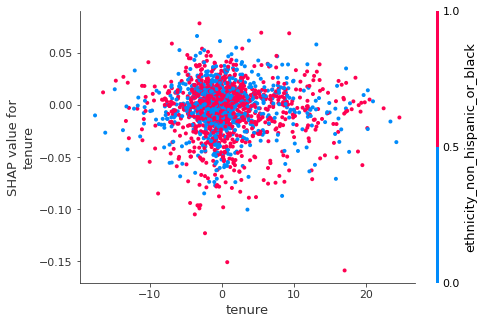

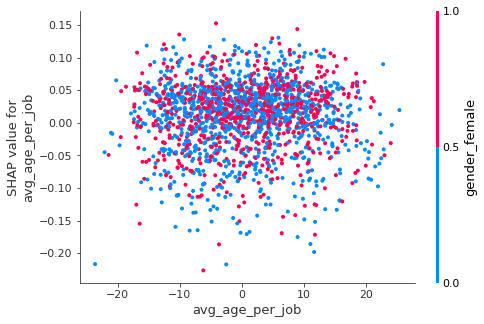

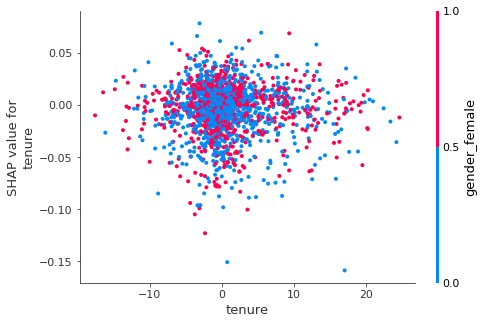

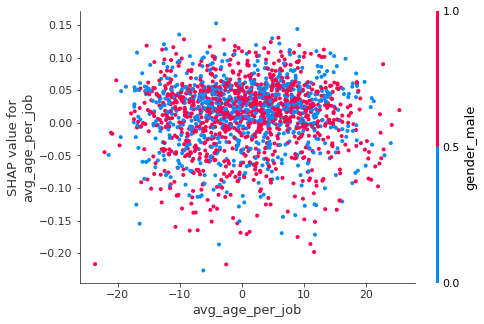

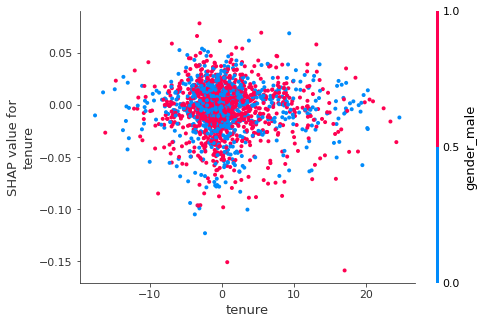

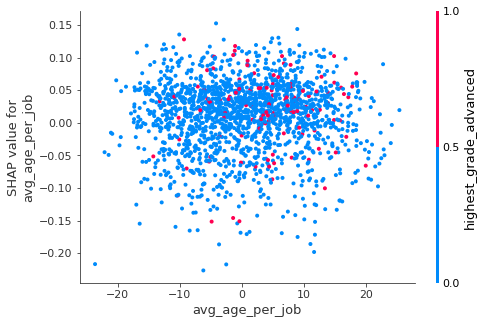

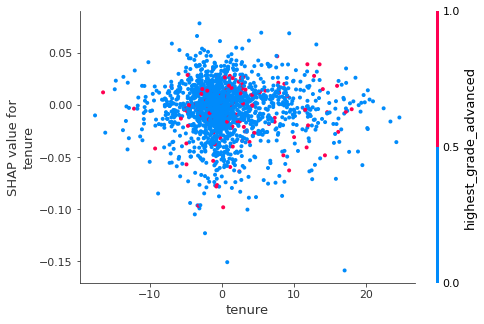

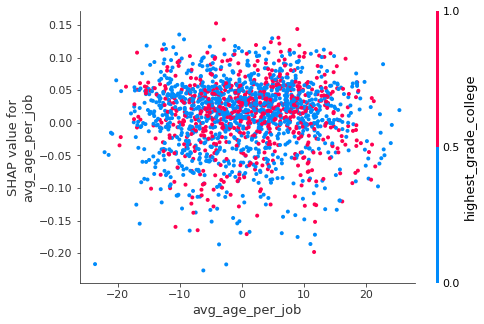

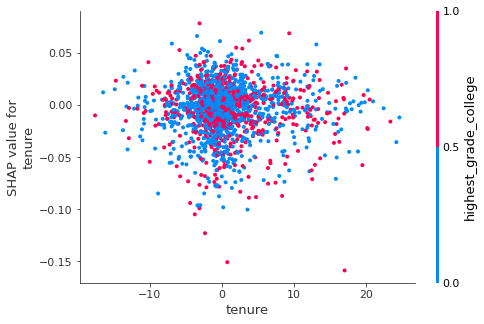

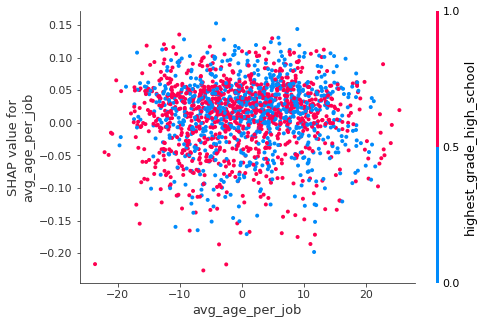

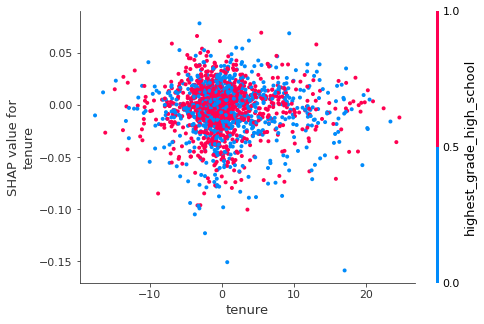

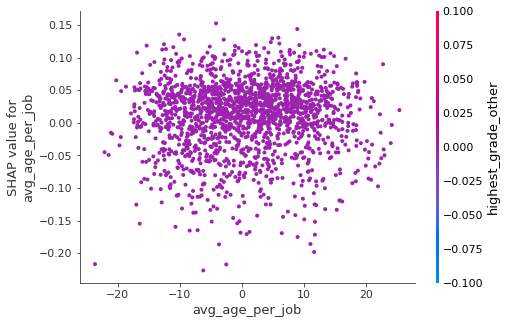

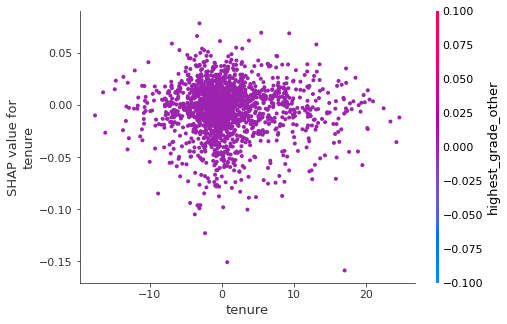

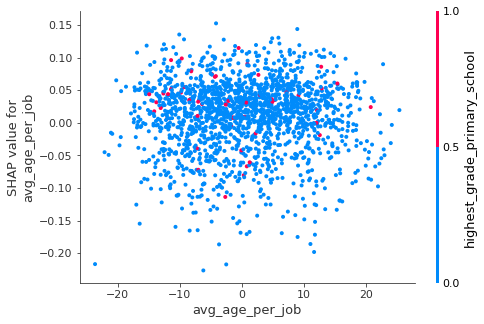

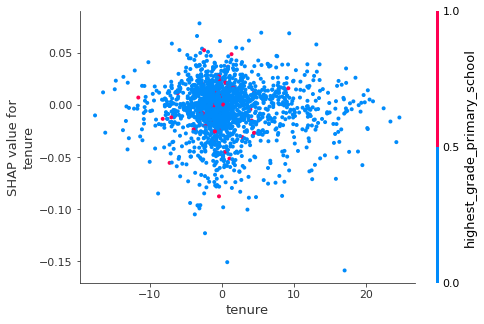

In [51]:
for f in X_test.columns:
  for v in ['avg_age_per_job', 'tenure']:
    if f != v:
      shap.dependence_plot(v, shap_values, X_test[:shap_values.shape[0]], interaction_index=f)

In [53]:
pd.set_option('display.max_columns', None)

# most average people
X_test[:shap_values.shape[0]].describe()

urban  net_family_income   job_number        union       public  \
count  1782.000000        1782.000000  1782.000000  1782.000000  1782.000000   
mean      0.783951           0.165097     1.194164     0.190797     0.354097   
std       0.411664           1.253661     0.535552     0.393040     0.478373   
min       0.000000         -10.696788     1.000000     0.000000     0.000000   
25%       1.000000          -0.197187     1.000000     0.000000     0.000000   
50%       1.000000           0.331400     1.000000     0.000000     0.000000   
75%       1.000000           0.755123     1.000000     0.000000     1.000000   
max       1.000000           3.847526     5.000000     1.000000     1.000000   

        hourly_pay  avg_age_per_job       tenure  rotter_score  \
count  1782.000000      1782.000000  1782.000000   1782.000000   
mean      0.041184         0.545156     0.653082     -0.143116   
std       0.554663         8.937937     5.455549      2.248721   
min      -3.886432       -23.625000   -17.541667     -3.643378   
25%      -0.168316        -6.256731    -2.299038     -1.643378   
50%       0.045471         0.327123    -0.372059     -0.643378   
75%       0.284514         7.309495     2.599578      1.356622   
max       4.807503        25.389957    24.561813      8.356622   

       rosenberg_score   pay_tenure      pay_age  religion_catholic  \
count      1782.000000  1782.000000  1782.000000        1782.000000   
mean          0.143291     5.062040     5.293695           0.382155   
std           3.900819    43.226907    74.105787           0.486051   
min         -11.622091  -135.532178  -177.465702           0.000000   
25%          -3.622091   -17.854754   -51.093024           0.000000   
50%          -0.122091    -2.660638     3.629095           0.000000   
75%           3.377909    20.109336    61.078134           1.000000   
max           6.377909   191.722816   290.491116           1.000000   

       religion_christian  religion_jewish  religion_no_religion  \
count         1782.000000      1782.000000           1782.000000   
mean             0.486532         0.005051              0.032548   
std              0.499959         0.070907              0.177499   
min              0.000000         0.000000              0.000000   
25%              0.000000         0.000000              0.000000   
50%              0.000000         0.000000              0.000000   
75%              1.000000         0.000000              0.000000   
max              1.000000         1.000000              1.000000   

       religion_other  ethnicity_black  ethnicity_hispanic  \
count     1782.000000      1782.000000         1782.000000   
mean         0.093715         0.240741            0.181257   
std          0.291514         0.427653            0.385339   
min          0.000000         0.000000            0.000000   
25%          0.000000         0.000000            0.000000   
50%          0.000000         0.000000            0.000000   
75%          0.000000         0.000000            0.000000   
max          1.000000         1.000000            1.000000   

       ethnicity_non_hispanic_or_black  gender_female  gender_male  \
count                      1782.000000    1782.000000  1782.000000   
mean                          0.578002       0.421998     0.578002   
std                           0.494017       0.494017     0.494017   
min                           0.000000       0.000000     0.000000   
25%                           0.000000       0.000000     0.000000   
50%                           1.000000       0.000000     1.000000   
75%                           1.000000       1.000000     1.000000   
max                           1.000000       1.000000     1.000000   

       highest_grade_advanced  highest_grade_college  \
count              1782.00000            1782.000000   
mean                  0.06734               0.350168   
std                   0.25068               0.477156   
min                   0.00000 

In [76]:
avg_people = X_test.loc[(X_test['highest_grade_high_school'] == 1) & 
                      ((X_test['net_family_income'] > 0.30) & (X_test['net_family_income'] < 0.35)) &
                      (X_test['gender_male'] == 1) &
                      (X_test['ethnicity_non_hispanic_or_black'] == 1) &
                      (X_test['religion_christian'] == 1) &
                      (X_test['urban'] == 1)]

In [82]:
avg_indices = avg_people.index.tolist()

In [85]:
shap.initjs()

# explainer.expected_value = mean job satisfaction
# shap_values for each feature of each row of X_test
# X_test row to explain

for i in avg_indices:
  if i < shap_values.shape[0]:
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_test[i:i+1]))